In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from bertopic import BERTopic

from IPython.display import display

## Data

In [2]:
def load_ids(ids_dir: str) -> np.ndarray:
    files = sorted(Path(ids_dir).glob("batch_*.txt"))
    if not files:
        raise FileNotFoundError(f"No txt files found in {ids_dir}")
    ids = []
    for file in files:
        with open(file) as f:
            ids.extend(f.read().splitlines())
    return np.array(ids)    

# IDs in the order they were embedded
ids = load_ids("../runs/embeddings/queries_all_datasets.multilingual-e5-large/ids")
print(ids[:5])

['1531533' '1531537' '1531541' '1531542' '1531547']


In [3]:
# Load queries
df_queries = pd.read_csv("../runs/all_datasets_queries.csv", low_memory=False)
# sort df according to order in ids list:
df_queries["id"] = df_queries["id"].astype(str)
df_queries = df_queries.set_index("id").loc[ids].reset_index()

print(df_queries.shape)

(1540199, 6)


In [4]:
df_queries.head(2)

,id,original_id,original_query,split,dataset,query
0,1531533,5987916,qué creó alfred nobel,test,messirve,que creo alfred nobel
1,1531537,5987922,qué creó charles darwin,test,messirve,que creo charles darwin


In [5]:
df_queries["dataset"].value_counts()

dataset
mmarco      815710
messirve    701354
sqac         18810
miracl        4325
Name: count, dtype: int64

## Topics

In [6]:
class TopicResults:

    def __init__(self, version: str):
        self.version = version
        self.topic_model = BERTopic.load(f"../runs/bertopic_{version}/model")

    @staticmethod
    def _get_repr_docs(df, topic_model, n=10) -> pd.DataFrame:
        """Get representative documents for each topic in a df"""
        df_tmp = df.rename(columns={"id": "ID"})[["ID", "Document", "Topic"]].copy()
        repr_doc_mappings, repr_docs, repr_doc_indices, repr_doc_ids = topic_model._extract_representative_docs(
            c_tf_idf=topic_model.c_tf_idf_,
            documents=df_tmp,
            topics=topic_model.topic_representations_,
            nr_samples=5_000,
            nr_repr_docs=n
        )
        df_out = pd.DataFrame(repr_doc_mappings.items(), columns=["Topic", "Document"])
        df_out = df_out.explode("Document")
        df_out["is_repr_doc"] = True
        return df_out

    def _add_topic_data(self, reduce_outliers=False) -> None:
        df_topics = self.topic_model.get_document_info(df_queries["query"], df=df_queries)
        if reduce_outliers:
            docs = df_topics["Document"].copy().tolist()
            old_topics = df_topics["Topic"].copy().tolist()
            new_topics = self.topic_model.reduce_outliers(docs, old_topics)
            self.topic_model.update_topics(
                docs=docs, topics=new_topics,
                vectorizer_model=self.topic_model.vectorizer_model, # maybe not right?
                ctfidf_model=self.topic_model.ctfidf_model, # maybe not right?
                n_gram_range=self.topic_model.n_gram_range,
            )
            df_topics = self.topic_model.get_document_info(df_queries["query"], df=df_queries)
        self.df_topics = df_topics

    def _add_topics_per_class(self) -> None:
        docs = self.df_topics["Document"].tolist()
        classes = self.df_topics["dataset"].tolist()
        topics_per_class = self.topic_model.topics_per_class(docs, classes)
        self.df_topics_per_class = topics_per_class

    def _add_repr_docs(self) -> None:
        df_repr_docs = pd.DataFrame()
        df_topics = self.df_topics.copy()
        for dataset in df_topics["dataset"].unique():
            df_ = self._get_repr_docs(df_topics[df_topics["dataset"] == dataset], self.topic_model)
            df_["Class"] = dataset
            df_repr_docs = pd.concat([df_repr_docs, df_])
        df_repr_docs = df_repr_docs.drop_duplicates(["Topic", "Document"]).reset_index(drop=True)
        # Add data to df_topics
        df_topics = df_topics.merge(df_repr_docs, how="left", on=["Topic", "Document"])
        df_topics["is_repr_doc"] = df_topics["is_repr_doc"].fillna(False)
        self.df_repr_docs = df_repr_docs
        self.df_topics = df_topics

    def make_data(self, reduce_outliers=False) -> None:
        # Add topic data to the queries df
        self._add_topic_data(reduce_outliers)
        # Topics per dataset
        self._add_topics_per_class()
        # Representative documents for each dataset-topic pair
        # We will only need one repr doc per topic per dataset
        # See https://github.com/MaartenGr/BERTopic/issues/1576#issuecomment-1759678417
        # Instead of doing it all at once, we will do it per dataset to guarantee that 
        # we get at least one repr doc per topic per dataset
        self._add_repr_docs()

    def make_summary(self, seed=34) -> None:
        df_res = self.df_topics_per_class.copy()
        df_res["rel_freq"] = df_res.groupby("Class")["Frequency"].transform(lambda x: x / x.sum())
        df_unique_topics = self.df_topics[["Topic", "Name", "Top_n_words"]].drop_duplicates()
        df_res = df_res.merge(df_unique_topics, on="Topic", how="left")
        df_res["rank"] = df_res.groupby("Class")["rel_freq"].rank(method="first", ascending=False).astype(int)
        # get one representative doc per topic per dataset:
        df_tmp = (
            self.df_topics
                .query("is_repr_doc")
                .groupby(["dataset", "Topic"])
                .sample(1, random_state=seed)
                [["dataset", "Topic", "original_query"]]
                .reset_index(drop=True)
                .rename(columns={"original_query": "repr_doc", "dataset": "Class"})
        )
        df_res = df_res.merge(df_tmp, on=["Class", "Topic"], how="left")
        self.df_res = df_res

    def make_table(self, n_topics: int = 5) -> pd.DataFrame:
        """We want Table: top N topics in each dataset
        (col: dataset, values: topic, rel_frequency, etc.)
        """
        table = self.df_res[self.df_res["rank"] <= n_topics].copy()
        # concat Frequency and rel_freq as "Frequency (rel_freq: %)"
        table["relevance"] = "n=" + table["Frequency"].apply(lambda x: f"{x:,}").astype(str) + \
            " (" + (table["rel_freq"] * 100).round(1).astype(str) + "%)"
        # Topic format: number (name: remove first number and _ from Name)
        table["topic"] = table["Topic"].astype(str) + " (" + table["Name"].str.split("_").str[1:].str.join("_") + ")"
        # summary: concat Name \n relevance \n Words \n repr_doc
        table["summary"] = table["topic"] + "\n" + table["relevance"] + "\n" + table["Words"] + "\n" + table["repr_doc"]
        table = table[["rank", "Class", "summary"]].reset_index(drop=True).copy()
        # one column per Class, rows: rank, value: summary
        table = table.pivot(index="rank", columns="Class", values="summary")
        # Dataset order:
        table = table[["messirve", "mmarco", "miracl", "sqac"]]
        return table



## KMeans 

In [7]:
versions = ["kmeans_25", "kmeans_30", "kmeans_50"]

res = {}
for version in versions:
    print(f"Processing {version}")
    tr = TopicResults(version)
    tr.make_data() # df_topics, df_topics_per_class, df_repr_docs
    tr.make_summary(seed=1979) # df_res
    tab = tr.make_table(n_topics=8)
    res[version] = (tr, tab)


Processing kmeans_25


2024-10-15 13:23:50,657 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


4it [00:05,  1.46s/it]
2024-10-15 13:24:03,609 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


Processing kmeans_30


4it [00:05,  1.48s/it]
2024-10-15 13:24:17,147 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


Processing kmeans_50


4it [00:05,  1.43s/it]


In [8]:
# # Top 5 topics per dataset:
# for version, (tr, _) in res.items():
#     print(version)
#     display(tr.df_topics_per_class.sort_values(["Class", "Frequency"], ascending=False).groupby("Class").head(6))

### Tables

In [9]:
to_keep = "kmeans_30"

tr = res[to_keep][0]
tab = res[to_keep][1]

In [10]:
display(tab.style.set_properties(**{
    'text-align': 'center',
    'white-space': 'pre-wrap',
}))


Class,messirve,mmarco,miracl,sqac
rank,,,,
1,"2 (causa_causas_duele_razones) n=61,797 (8.8%) duele, razones, motivos, da, salen porque da dolor y ardor en la boca del estomago","5 (costo_cuesta_salario_promedio) n=60,499 (7.4%) costo, cuesta, salario, promedio, precio costo promedio de la universidad","19 (guerra_mundial_independencia_presidente) n=498 (11.5%) paises, guerra, nazi, pais, imperio ¿Cuándo ocurrió la primera guerra mundial?","0 (murio_canta_juega_pelicula) n=4,314 (22.9%) cargo, profesion, equipo, partido, dirige ¿En qué equipo juega Ronaldo?"
2,"3 (importante_derechos_sociales_cuales) n=48,188 (6.9%) consiste, derechos, importante, sociales, cuales porque son importante los derechos humanos","1 (trata_consiste_significa_hace) n=59,825 (7.3%) significa, empresa, hace, archivo, red la empresa de redes más rica del mundo","0 (murio_canta_juega_pelicula) n=455 (10.5%) cantante, banda, llama, personaje, pelicula ¿Qué actor interpretó a Ray Charles en el cine?","19 (guerra_mundial_independencia_presidente) n=2,693 (14.3%) guerra, gobierno, pais, presidente, mundial ¿En qué continente tuvo lugar la Guerra de la Independencia Argentina?"
3,"4 (queda_encuentra_region_pertenece) n=45,908 (6.5%) queda, region, pertenece, continente, rio en qué continente queda australia","6 (impuestos_credito_obtener_licencia) n=47,105 (5.8%) impuestos, credito, obtener, licencia, seguro ¿Cuánto tiempo se tarda en obtener un reembolso de impuestos?","25 (invento_descubrio_creo_primer) n=380 (8.8%) primer, primera, invento, fundo, creo ¿Dónde se inventó el baloncesto?","4 (queda_encuentra_region_pertenece) n=1,733 (9.2%) lugar, adonde, halla, encuentra, ciudad ¿Con qué territorio limita Dubái por su parte occidental?"
4,"0 (murio_canta_juega_pelicula) n=43,578 (6.2%) murio, juega, canta, gano, equipo con quien canta michael jackson todo mi amor eres tu","0 (murio_canta_juega_pelicula) n=46,039 (5.6%) murio, canta, elenco, interpreta, pelicula quien canta la cancion uno","24 (biblia_jesus_dios_santo) n=319 (7.4%) biblia, historia, mitologia, religion, dios ¿Quién era David en la Biblia?","24 (biblia_jesus_dios_santo) n=1,485 (7.9%) obra, obras, segun, jesus, iglesia ¿Quiénes escribieron los evangelios que se creen bastante cercanos a la época en que vivió Jesús de Nazaret?"
5,"11 (cuantas_cuantos_existen_personas) n=43,539 (6.2%) cuantas, cuantos, existen, municipios, jugadores cuántos idiomas indígenas existen en méxico","9 (sintomas_enfermedad_causar_efectos) n=44,004 (5.4%) sintomas, enfermedad, causar, efectos, enfermedades ¿Qué enfermedad causa dolor de estómago, diarrea y es contagiosa?","4 (queda_encuentra_region_pertenece) n=313 (7.2%) paises, capital, pais, ciudad, ciudades ¿En qué región se encuentra la República de las Islas Marshall?","11 (cuantas_cuantos_existen_personas) n=1,139 (6.1%) personas, cuantas, cuantos, victimas, fallecieron ¿Cuántas personas utilizan este servicio en todo mundo?"
6,"7 (sirve_tomar_medicamento_ayuda) n=36,811 (5.2%) sirve, tomar, medicamento, mg, cura que pastilla puedo tomar para el dolor de cabeza","8 (numero_telefono_windows_computadora) n=43,946 (5.4%) numero, telefono, windows, computadora, excel Excel número de teléfono de servicio al cliente","13 (color_colores_animal_tipo) n=312 (7.2%) botanica, cuales, vegetacion, populares, caracteristicas ¿Cuántos colores puede reconocer un perro?","20 (hora_horario_temporada_dia) n=978 (5.2%) produjo, comicios, competicion, lugar, partido ¿Cómo se pasa del horario de invierno al de verano?"
7,"12 (energia_agua_tierra_ambiente) n=30,631 (4.4%) energia, agua, tierra, ambiente, planeta qué tipo de movimiento realiza el planeta tierra alrededor del sol","14 (definicion_definir_significa_biologia) n=43,221 (5.3%) definicion, definir, significa, medica, biologia definición de sobre","3 (importante_derechos_sociales_cuales) n=261 (6.0%) principales, estudia, diferencia, cuales, paleontologos ¿Qué habilidades debe tener un director ejecutivo?","25 (invento_descubr

In [11]:
def safe_latex_string(s: str) -> str:
    s = s.replace("_", "\\_")
    s = s.replace("&", "\\&")
    s = s.replace("%", "\\%")
    return s

In [12]:
# Iterate over each row, and for each line in each row, print it in the format
# xyz & abc & ... \\

for i, row in tab.iterrows():
    row_ = row.values
    items = row_[0].split("\n")
    n_values = len(items)
    n_cols = len(row_)
    for j in range(n_values):
        lines = []
        for k in range(n_cols):
            item = row_[k].split("\n")[j]
            if j == 0:
                # Keep only the digits of topic:
                item = "Topic " + item.split(" ")[0]
            clean_item = safe_latex_string(item)
            if j == 3:
                # Add italics to repr doc
                clean_item = f"\\textit{{{clean_item}}}"
            if j == 0:
                # textsc to topic:
                clean_item = f"\\textsc{{{clean_item}}}"
            lines.append(clean_item)
        line = " & ".join(lines) + " \\\\"
        print(line)
    print("\hline")
    


\textsc{Topic 2} & \textsc{Topic 5} & \textsc{Topic 19} & \textsc{Topic 0} \\
n=61,797 (8.8\%) & n=60,499 (7.4\%) & n=498 (11.5\%) & n=4,314 (22.9\%) \\
duele, razones, motivos, da, salen & costo, cuesta, salario, promedio, precio & paises, guerra, nazi, pais, imperio & cargo, profesion, equipo, partido, dirige \\
\textit{porque da dolor y ardor en la boca del estomago} & \textit{costo promedio de la universidad} & \textit{¿Cuándo ocurrió la primera guerra mundial?} & \textit{¿En qué equipo juega Ronaldo?} \\
\hline
\textsc{Topic 3} & \textsc{Topic 1} & \textsc{Topic 0} & \textsc{Topic 19} \\
n=48,188 (6.9\%) & n=59,825 (7.3\%) & n=455 (10.5\%) & n=2,693 (14.3\%) \\
consiste, derechos, importante, sociales, cuales & significa, empresa, hace, archivo, red & cantante, banda, llama, personaje, pelicula & guerra, gobierno, pais, presidente, mundial \\
\textit{porque son importante los derechos humanos} & \textit{la empresa de redes más rica del mundo} & \textit{¿Qué actor interpretó a Ray 

In [13]:
# specific examples: 
us_geo_docs = tr.df_repr_docs.query("Topic == 23 and Class == 'mmarco'")["Document"].values
print("--mmarco")
print(*us_geo_docs, sep="\n")

messirve_geo_docs = tr.df_repr_docs.query("Topic == 4 and Class == 'messirve'")["Document"].values
print("--messirve")
print(*messirve_geo_docs, sep="\n")

us_misc_docs = tr.df_repr_docs.query("Topic == 0 and Class == 'mmarco'")["Document"].values
print("--mmarco")
print(*us_misc_docs, sep="\n")

messirve_misc_docs = tr.df_repr_docs.query("Topic == 0 and Class == 'messirve'")["Document"].values
print("--messirve")
print(*messirve_misc_docs, sep="\n")

--mmarco
dallas nc se encuentra en que condado
en que condado se encuentra grove city ohio
en que condado se encuentra el municipio comercial de nueva jersey
cual es el condado de washington tx
en que condado se encuentra el centro de la ciudad de iowa
en que condado se encuentra el paso tx
en que condado se encuentra la ciudad de chicago
en que condado se encuentra
en que condado se encuentra la ciudad de texas tx
en que condado se encuentra el puerto norte florida
--messirve
donde queda riaño
a cual region pertenece mexico
en donde queda ciudad del este
en que continente queda australia
en que region se encuentra mexico
en que continente se encuentra ubicado colombia
donde queda logroño
por donde queda montañita
por donde queda españa
a que region de america pertenece la isla de santo domingo
--mmarco
quien canta la cancion ahora mismo
cuando murio george jones el cantante
quien gano el premio al mejor actor de reparto por los oscars
en que equipo juega michael sam
quien canta la can

### Figures

In [14]:
dataset_names_dict = {
    "messirve": "messIRve",
    "mmarco": "mMARCO",
    "miracl": "MIRACL",
    "sqac": "SQAC"
}

237.3


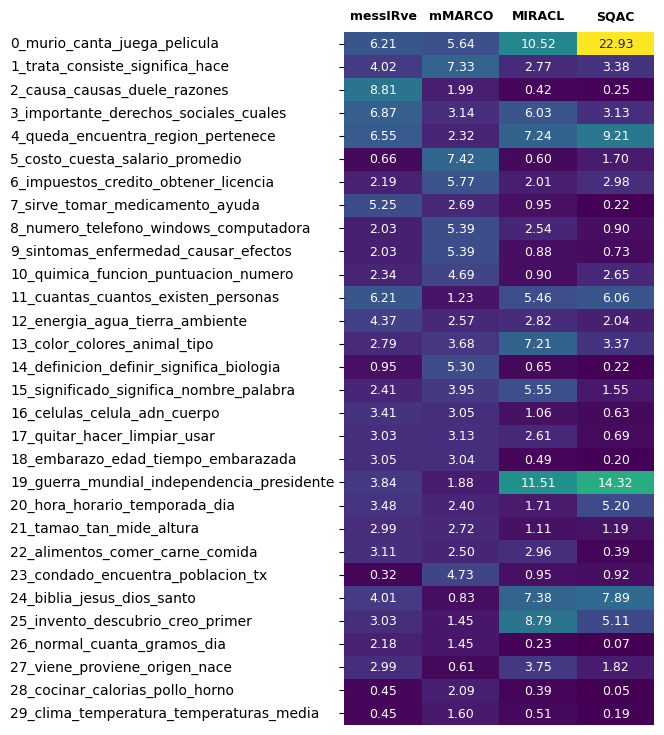

In [15]:
# Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

def topics_heatmap(tr, dataset_names_dict, topic_names=None):
    df_tmp = tr.df_res[["Name", "rel_freq", "Class", "rank"]].copy()
    # Sort dataset
    df_tmp["dataset"] = df_tmp["Class"].map(dataset_names_dict)
    df_tmp["dataset"] = pd.CategoricalIndex(
        df_tmp["dataset"], categories=dataset_names_dict.values(), ordered=True)
    # Sort topic
    # topic_order = df_tmp.query("Class == 'messirve'").sort_values("rank")["Name"].tolist() # by messirve rank
    topic_order = df_tmp["Name"].unique()
    df_tmp["topic"] = pd.CategoricalIndex(df_tmp["Name"], categories=topic_order, ordered=True)

    df_plot = df_tmp.pivot(index="topic", columns="dataset", values="rel_freq")
    df_plot = df_plot * 100 # to percentage
    if topic_names is not None:
        df_plot.index = topic_names
    # ylabs_padding = df_plot.index.str.len().max() * 5.5
    ylabs_padding = df_plot.index.str.len().max() * 5.65
    print(ylabs_padding)
    
    plt.figure(figsize=(4, 9))
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="viridis", cbar=False, annot_kws={"size": 9})
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
    plt.tick_params(axis='y', pad=ylabs_padding)
    plt.yticks(fontsize=10, ha='left')
    plt.xticks(fontsize=9, rotation=0, fontweight='bold')
    plt.grid(False)
    plt.xlabel(None)
    plt.ylabel(None)


topics_heatmap(tr, dataset_names_dict)
plt.savefig("../runs/plots/datasets_topics.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

242.95000000000002


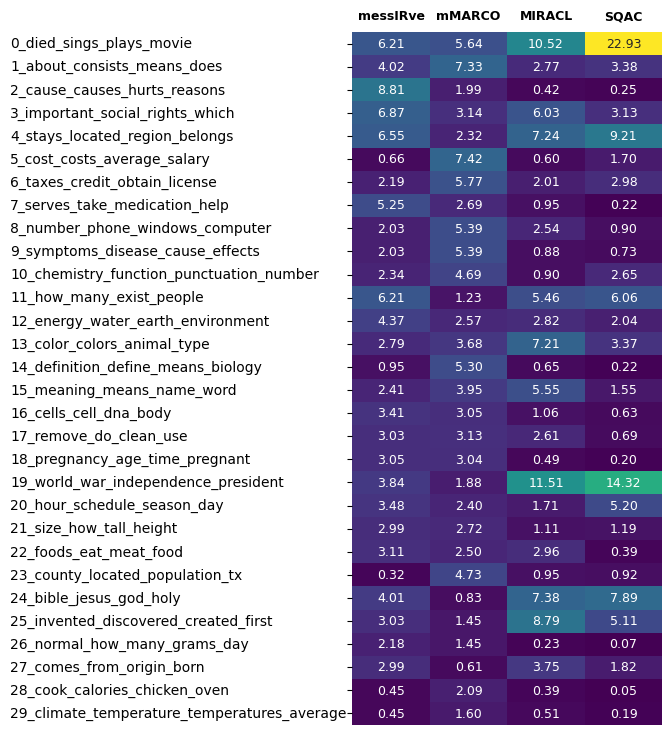

In [16]:
# Here we manually replace the topics names for names in english translated
translated_names = [
    "0_died_sings_plays_movie",
    "1_about_consists_means_does",
    "2_cause_causes_hurts_reasons",
    "3_important_social_rights_which",
    "4_stays_located_region_belongs",
    "5_cost_costs_average_salary",
    "6_taxes_credit_obtain_license",
    "7_serves_take_medication_help",
    "8_number_phone_windows_computer",
    "9_symptoms_disease_cause_effects",
    "10_chemistry_function_punctuation_number",
    "11_how_many_exist_people",
    "12_energy_water_earth_environment",
    "13_color_colors_animal_type",
    "14_definition_define_means_biology",
    "15_meaning_means_name_word",
    "16_cells_cell_dna_body",
    "17_remove_do_clean_use",
    "18_pregnancy_age_time_pregnant",
    "19_world_war_independence_president",
    "20_hour_schedule_season_day",
    "21_size_how_tall_height",
    "22_foods_eat_meat_food",
    "23_county_located_population_tx",
    "24_bible_jesus_god_holy",
    "25_invented_discovered_created_first",
    "26_normal_how_many_grams_day",
    "27_comes_from_origin_born",
    "28_cook_calories_chicken_oven",
    "29_climate_temperature_temperatures_average",
]

topics_heatmap(tr, dataset_names_dict, topic_names=translated_names)
plt.savefig("../runs/plots/datasets_topics_translated.pdf", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [17]:
!cp ../runs/plots/datasets_topics_translated.pdf ../latex/plots/